In [57]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

In [58]:
# Step-by-Step Implementation

# Load Historical Asset Prices

# Replace 'filename.csv' with the path to your CSV file
niftybees_history = '300000/Equity_etf/NIFTYBES_Historical_PR_08062022to08062025.csv'

# Read the CSV file into a DataFrame
niftybees = pd.read_csv(niftybees_history)

# Print the DataFrame
niftybees = niftybees['Open']

# ---------------------------------------------

# Replace 'filename.csv' with the path to your CSV file
bankbees_history = '300000/Equity_etf/BANKBES Historical Data.csv'

# Read the CSV file into a DataFrame
bankbees = pd.read_csv(bankbees_history)

# Print the DataFrame
bankbees = bankbees['Open']

# ---------------------------------------------

# Replace 'filename.csv' with the path to your CSV file
goldbees_history = '300000/Equity_etf/GBES Historical Data.csv'

# Read the CSV file into a DataFrame
goldbees = pd.read_csv(goldbees_history)

# Print the DataFrame
goldbees = goldbees['Open']

# ---------------------------------------------

# Replace 'filename.csv' with the path to your CSV file
itbees_history = '300000/Equity_etf/ITBES Historical Data.csv'

# Read the CSV file into a DataFrame
itbees = pd.read_csv(itbees_history)

# Print the DataFrame
itbees = itbees['Open']

itbees.dtype

dtype('float64')

In [59]:
niftybees = niftybees.astype(int)

bankbees = bankbees.astype(int)

goldbees = goldbees.astype(int)

itbees = itbees.astype(int)

In [60]:
df = pd.DataFrame({'niftybees':niftybees, 'bankbees': bankbees, 'goldbees':goldbees, 'itbees':itbees})
df

,niftybees,bankbees,goldbees,itbees
0,278,573,81,41
1,277,570,83,41
2,276,571,81,41
3,278,574,82,41
4,276,572,80,40
...,...,...,...,...
738,172,336,44,33
739,175,347,44,30
740,178,355,44,30
741,179,351,44,30


In [61]:
# Calculate log returns
log_returns = np.log(df / df.shift(1)).dropna()

log_returns

,niftybees,bankbees,goldbees,itbees
1,-0.003604,-0.005249,0.024391,0.000000
2,-0.003617,0.001753,-0.024391,0.000000
3,0.007220,0.005240,0.012270,0.000000
4,-0.007220,-0.003490,-0.024693,-0.024693
5,0.010811,0.000000,-0.012579,0.000000
...,...,...,...,...
738,-0.005797,-0.005935,0.022990,0.129212
739,0.017291,0.032214,0.000000,-0.095310
740,0.016998,0.022793,0.000000,0.000000
741,0.005602,-0.011332,0.000000,0.000000


In [62]:
# Feature Engineering for Clustering

# Rolling features for clustering (30-day window)
window = 30

rolling_volatility = log_returns.rolling(window).std().mean(axis=1)   # average volatility across assets
rolling_momentum = log_returns.rolling(window).mean().mean(axis=1)    # average momentum (returns) across assets
rolling_correlation = log_returns.rolling(window).corr()

# Compute average pairwise correlation at each time
correlation_values = []
for i in range(window - 1, len(log_returns)):
    corr_matrix = rolling_correlation.iloc[i * len(log_returns.columns):(i+1) * len(log_returns.columns)]
    avg_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).mean().mean()
    correlation_values.append(avg_corr)

# Align indexes
correlation_series = pd.Series(correlation_values, index=rolling_volatility.index[-len(correlation_values):])

# Combine into features DataFrame
features = pd.DataFrame({
    'volatility': rolling_volatility[-len(correlation_values):],
    'momentum': rolling_momentum[-len(correlation_values):],
    'correlation': correlation_series
}).dropna()

In [63]:
# Scale Features

from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [64]:
# Clustering with KMeans (to detect regimes)

from sklearn.cluster import KMeans

# Apply KMeans to detect regimes
kmeans = KMeans(n_clusters=10, random_state=42)
regimes = kmeans.fit_predict(scaled_features)

# Add regime labels to the log_returns DataFrame (aligning with features index)
log_returns_regime = log_returns.loc[features.index].copy()
log_returns_regime['Regime'] = regimes


C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [65]:
# Define Portfolio Optimization Function

from scipy.optimize import minimize

def optimize_portfolio(returns, risk_free_rate=0.0675):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    num_assets = len(mean_returns)
    initial_weights = np.array([1/num_assets] * num_assets)

    def neg_sharpe(weights):
        port_return = np.dot(weights, mean_returns) * 252
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
        sharpe = (port_return - risk_free_rate) / port_vol
        return -sharpe

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))

    result = minimize(neg_sharpe, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

In [66]:
# Run Optimization by Market Regime

# Optimize portfolio for each market regime
optimized_weights_by_regime = {}

for regime in np.unique(regimes):
    regime_data = log_returns_regime[log_returns_regime['Regime'] == regime].drop(columns='Regime')
    weights = optimize_portfolio(regime_data)
    optimized_weights_by_regime[regime] = weights
    print(f"\n📈 Regime {regime} Optimal Weights:")
    for asset, weight in zip(regime_data.columns, weights):
        print(f"{asset}: {weight:.4f}")


📈 Regime 0 Optimal Weights:
niftybees: 0.6460
bankbees: 0.0000
goldbees: 0.3540
itbees: 0.0000

📈 Regime 1 Optimal Weights:
niftybees: 0.4946
bankbees: 0.0000
goldbees: 0.1318
itbees: 0.3736

📈 Regime 2 Optimal Weights:
niftybees: 0.0000
bankbees: 0.0000
goldbees: 0.0000
itbees: 1.0000

📈 Regime 3 Optimal Weights:
niftybees: 1.0000
bankbees: 0.0000
goldbees: 0.0000
itbees: 0.0000

📈 Regime 4 Optimal Weights:
niftybees: 0.0000
bankbees: 0.0000
goldbees: 0.0000
itbees: 1.0000

📈 Regime 5 Optimal Weights:
niftybees: 0.8468
bankbees: 0.0000
goldbees: 0.0000
itbees: 0.1532

📈 Regime 6 Optimal Weights:
niftybees: 0.3182
bankbees: 0.5539
goldbees: 0.0000
itbees: 0.1278

📈 Regime 7 Optimal Weights:
niftybees: 0.0000
bankbees: 0.9735
goldbees: 0.0265
itbees: 0.0000

📈 Regime 8 Optimal Weights:
niftybees: 0.0000
bankbees: 0.0000
goldbees: 1.0000
itbees: 0.0000

📈 Regime 9 Optimal Weights:
niftybees: 0.0000
bankbees: 0.0000
goldbees: 1.0000
itbees: 0.0000


C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


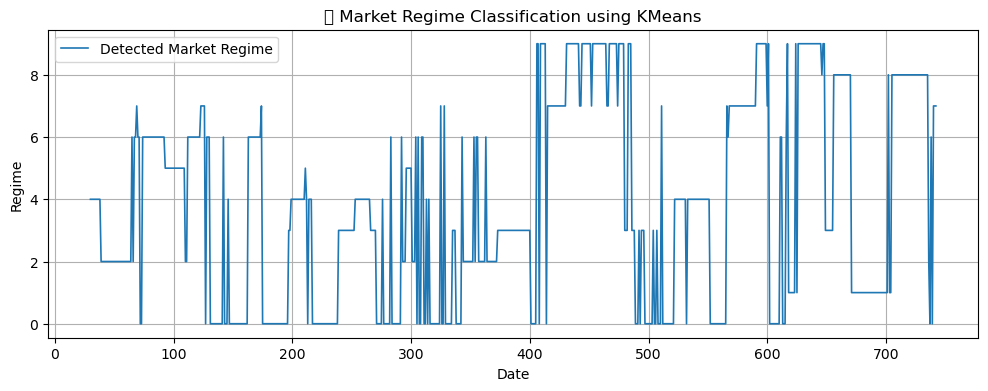

In [67]:
# Visualize Market Regimes

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(log_returns_regime.index, log_returns_regime['Regime'], label='Detected Market Regime', lw=1.2)
plt.title("📊 Market Regime Classification using KMeans")
plt.xlabel("Date")
plt.ylabel("Regime")
plt.grid(True)
plt.legend()
plt.show()

In [68]:
# Use the latest regime to dynamically choose weights:

current_regime = regimes[-1]
portfolio_weights = optimized_weights_by_regime[current_regime]
 
portfolio_weights

array([1.46718505e-15, 9.73497484e-01, 2.65025164e-02, 0.00000000e+00])